In [1]:
import sys
sys.path.insert(0, "./../")

import os
import utils_modelling as utils

In [2]:
path_dataset = "./../../../dataset_used_split"
path_train = os.path.join(path_dataset, "train")
path_val = os.path.join(path_dataset, "val")
path_test = os.path.join(path_dataset, "test")

In [3]:
train_img, train_mask = utils.load_img_mask(path_train)
val_img, val_mask = utils.load_img_mask(path_val)
test_img, test_mask = utils.load_img_mask(path_test)

In [4]:
trainset = utils.create_dataset(train_img, train_mask)
valset = utils.create_dataset(val_img, val_mask)
testset = utils.create_dataset(test_img, test_mask)

In [6]:
unet_custom = utils.custom_unet()
unet_custom, ev_loss, ev_acc = utils.train_model(unet_custom, trainset, valset, testset, "unet_model")
print(f"test loss: {ev_loss}", f"test accuracy: {ev_acc}", sep="\n")

test loss: 0.04806487634778023
test accuracy: 0.9829634428024292


In [33]:
for image, mask in testset.take(1):
    print(len(np.unique(pred)))
    break

479332


1/1 [==============================] - 0s 292ms/step
(16, 128, 128, 3)


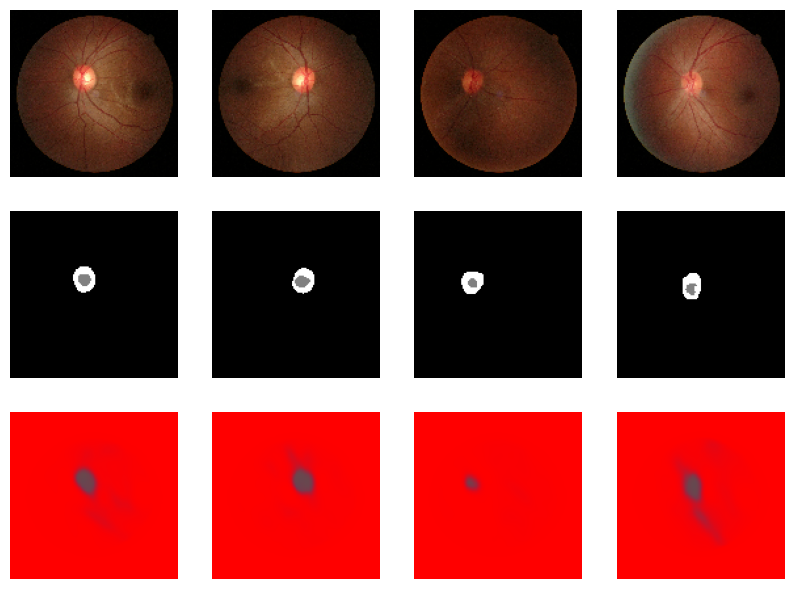

In [31]:
for image, mask in testset.take(1):
    pred = unet_custom.predict(image)

    print(pred.shape)
    plt.figure(figsize=(10, 10))
    for i in range(4):
        plt.subplot(4, 4, i+1)
        plt.imshow(image[i])
        plt.axis("off")
        plt.subplot(4, 4, i+5)
        plt.imshow(mask[i], cmap="gray")
        plt.axis("off")
        plt.subplot(4, 4, i+9)
        plt.imshow(pred[i], cmap="gray")
        plt.axis("off")
    break

### Visualize and Debug

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [14]:
for img, mask in trainset.take(1):
    break
np.unique(mask[2])

array([  0,  64, 255])

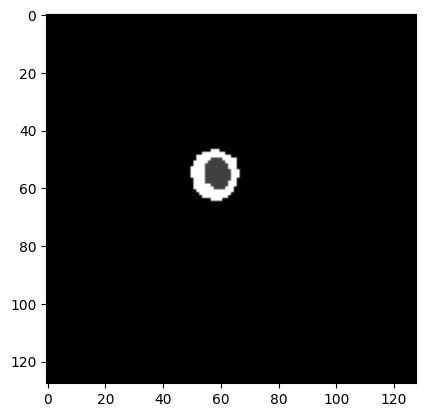

In [16]:
plt.imshow(mask[0], cmap="gray")

In [25]:
example_mask = train_mask[54]
example_mask = tf.io.read_file(example_mask)
example_mask = tf.image.decode_png(example_mask, channels=1)
example_mask = tf.image.resize(example_mask, (256, 256), method="nearest")
example_mask = tf.cast(example_mask, tf.int32)

dict_example = {}
for index, value in enumerate(sorted(np.unique(example_mask))):
    dict_example[value] = index
dict_example

{0: 0, 64: 1, 255: 2}

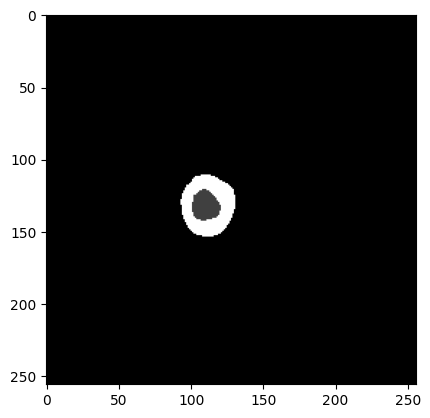

In [22]:
plt.imshow(example_mask, cmap="gray")

0 16 16


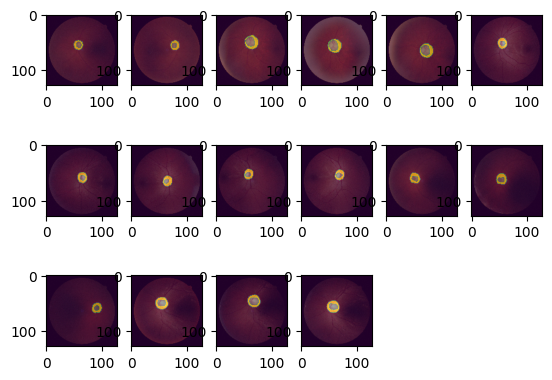

1 16 16


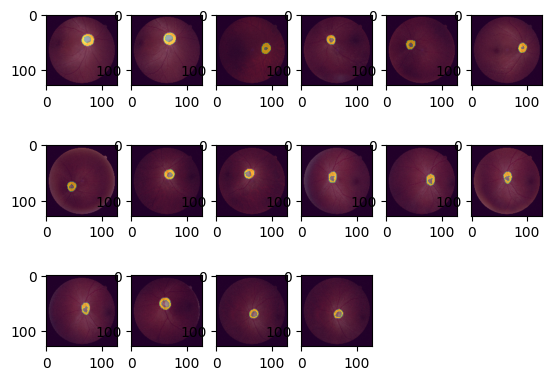

2 16 16


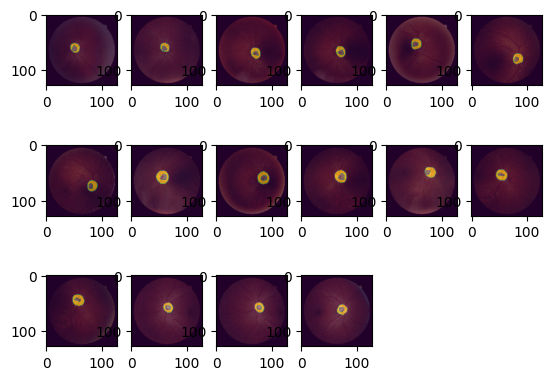

3 16 16


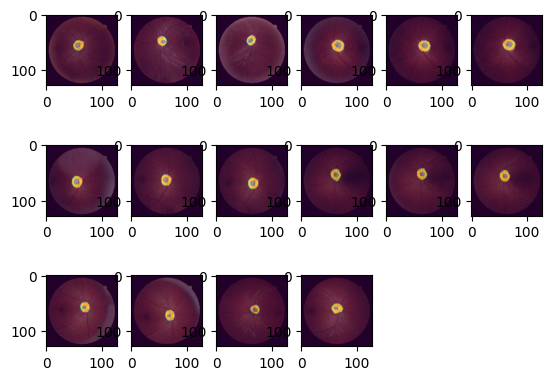

4 16 16


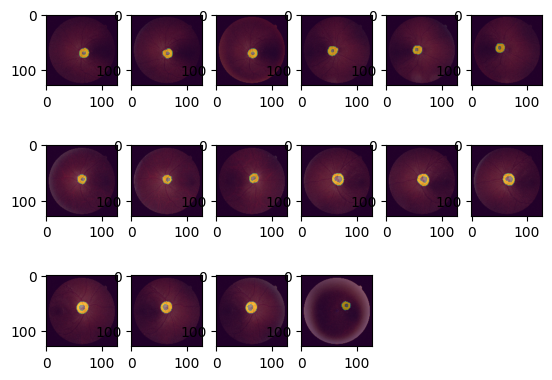

5 16 16


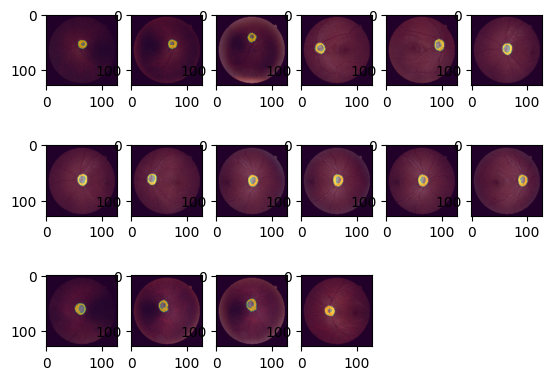

6 16 16


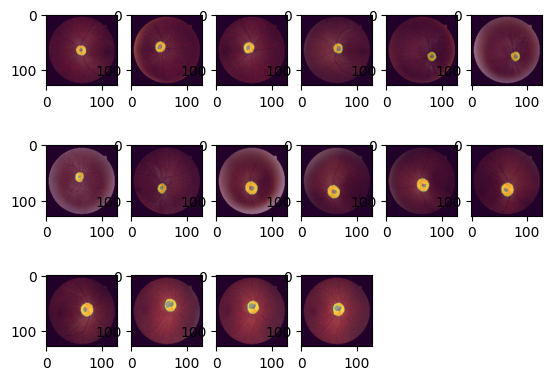

7 16 16


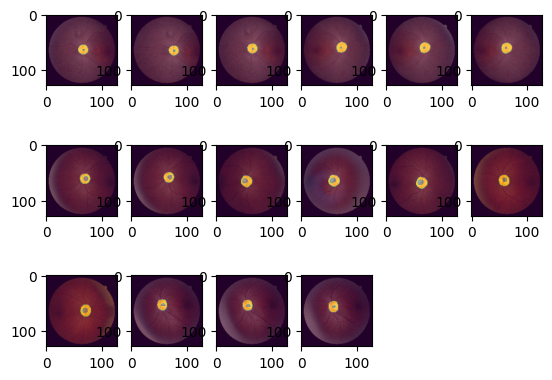

8 16 16


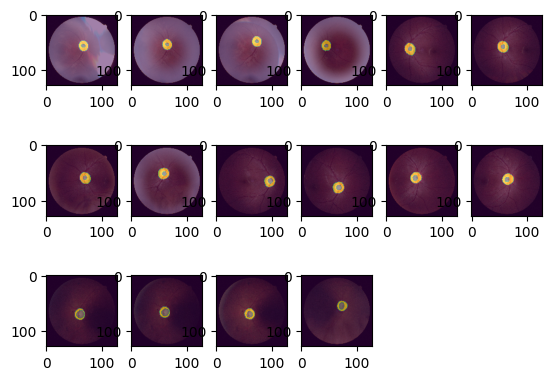

9 16 16


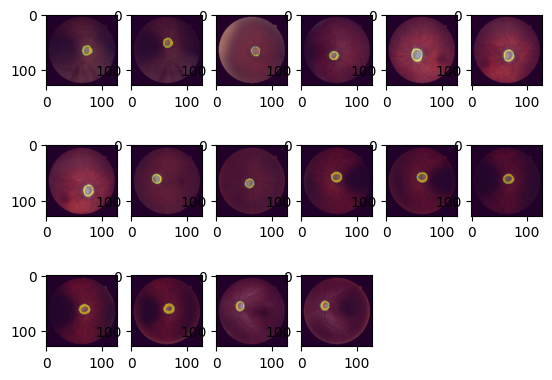

10 16 16


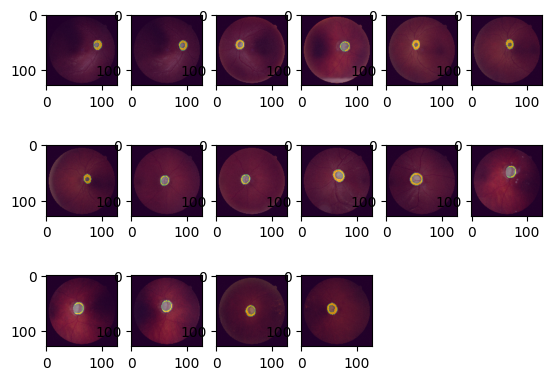

11 16 16


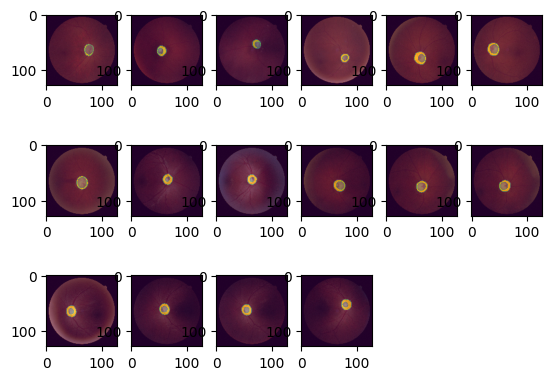

12 16 16


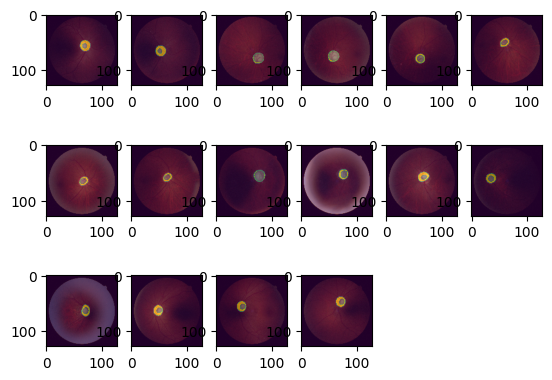

13 16 16


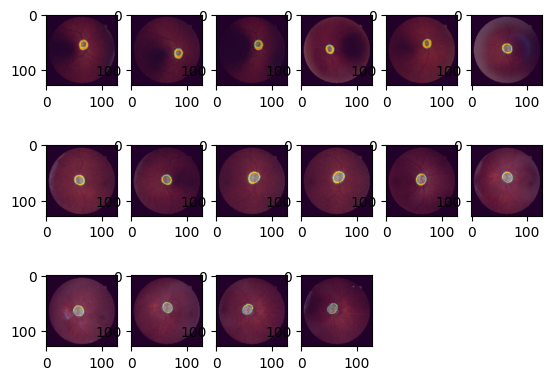

14 16 16


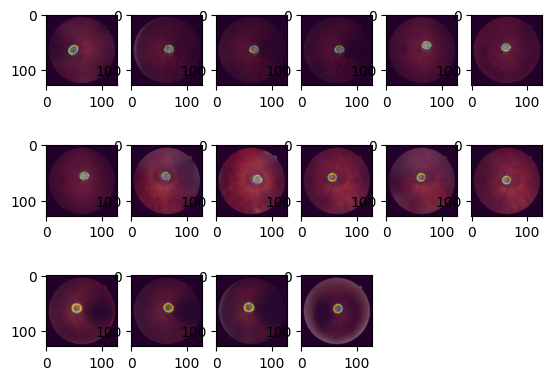

15 6 6


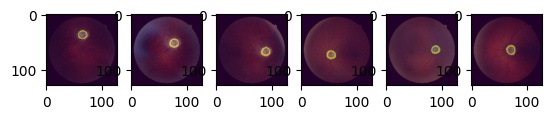

In [23]:
for indeks, (images, masks) in enumerate(trainset.take(16)):
    print(indeks, len(images), len(masks), sep=" ")
    for i in range(len(images)):
        plt.subplot(3, 6, i+1)
        plt.imshow(images[i])
        plt.imshow(masks[i], alpha=0.5)
    plt.show()